In [1]:
# CNN with 360 params and 2460 samples

In [2]:
from main import *

# Data Cleaned

In [120]:
semi_daily_heights_raw = pd.read_csv('source_data/snow_height.csv')
semi_daily_heights = just_semi_daily_snow_heights(semi_daily_heights_raw)

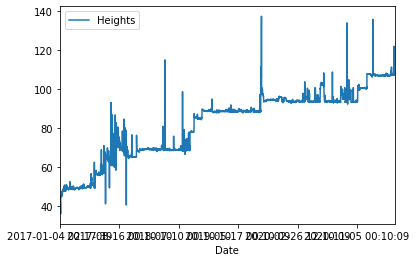

In [121]:
semi_daily_heights.set_index('Date').plot()

In [123]:
semi_daily_heights['Heights'] = semi_daily_heights['Heights'].ewm(span=80).mean()

In [124]:
semi_daily_heights['Date'] = [parse(x) for x in semi_daily_heights['Date']]

In [6]:
# semi_daily_heights['Heights'] = [h if abs(h-e) < 2 else e for h,e in zip(semi_daily_heights['Heights'], semi_daily_heights['Heights'].ewm(span=80).mean())]

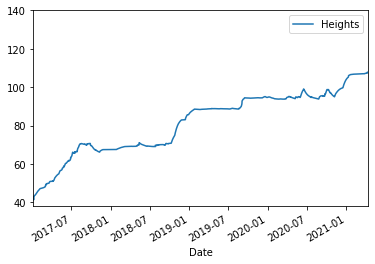

In [125]:
semi_daily_heights.set_index('Date').plot(yticks=range(40,160,20))

In [126]:
semi_daily_heights

,Date,Heights
0,2017-01-04 02:17:39,42.430000
1,2017-01-04 02:18:46,42.480625
2,2017-01-04 03:44:56,42.651262
3,2017-01-04 19:32:10,42.560126
4,2017-01-04 19:45:14,42.499164
...,...,...
2813,2021-04-10 12:10:09,107.829515
2814,2021-04-11 00:10:09,107.820885
2815,2021-04-11 12:10:07,107.827036
2816,2021-04-12 00:10:10,107.815998


# Get Weather

In [182]:
def day_of_year_to_date(day,year):
    # day must be an integer between [1,365]
    # year should be a 4 digit integer [0-9999]
    return datetime.datetime(year, 1, 1) + datetime.timedelta(day - 1)

In [183]:
def sample_num_to_time(num):
    # num must be integer [1-144]
    return datetime.timedelta(minutes=10*num)

# sample_num_to_time(1)

In [184]:
def get_south_pole_weather(directory='source_data/henry8985/'):
    dfs = []

    for file in os.listdir(directory):
    # file = '089850217.r'
        year  = int('20' + file[7:-2])
        month = int(file[5:7])
        df = pd.read_csv(directory + file,names=['Day','#','Temp','Pres','Ws','Wd','Hum','Dt'],skiprows=lambda x: x<=1,sep='\s+')
        df['Date'] = [day_of_year_to_date(day,year)+sample_num_to_time(td) for day,td in zip(df['Day'], df['#'])]
        dfs.append(df.drop(columns=['Day','#','Dt']))
    return pd.concat(dfs)

weather = get_south_pole_weather()

In [185]:
weather

,Temp,Pres,Ws,Wd,Hum,Date
0,-23.7,700.8,2.5,22.0,72.1,2017-01-01 00:10:00
1,-23.7,700.8,2.5,23.0,72.0,2017-01-01 00:20:00
2,-23.5,700.8,2.4,24.0,72.0,2017-01-01 00:30:00
3,-23.4,700.8,2.1,66.0,71.0,2017-01-01 00:40:00
4,-23.3,700.8,1.8,30.0,71.0,2017-01-01 00:50:00
...,...,...,...,...,...,...
4459,-30.2,686.2,1.8,114.0,65.0,2020-12-31 23:20:00
4460,-30.3,686.2,1.9,114.0,65.0,2020-12-31 23:30:00
4461,-30.2,686.1,2.0,111.0,65.0,2020-12-31 23:40:00
4462,-30.2,686.1,1.9,111.0,65.0,2020-12-31 23:50:00


In [186]:
# Get normalized weather

In [188]:
weather['Date']

0      2017-01-01 00:10:00
1      2017-01-01 00:20:00
2      2017-01-01 00:30:00
3      2017-01-01 00:40:00
4      2017-01-01 00:50:00
               ...        
4459   2020-12-31 23:20:00
4460   2020-12-31 23:30:00
4461   2020-12-31 23:40:00
4462   2020-12-31 23:50:00
4463   2021-01-01 00:00:00
Name: Date, Length: 157536, dtype: datetime64[ns]

# Get height differences due to weather differences

In [115]:
semi_daily_heights['Date']

0      2017-01-04 02:17:39
1      2017-01-04 02:18:46
2      2017-01-04 03:44:56
3      2017-01-04 19:32:10
4      2017-01-04 19:45:14
               ...        
2813   2021-04-10 12:10:09
2814   2021-04-11 00:10:09
2815   2021-04-11 12:10:07
2816   2021-04-12 00:10:10
2817   2021-04-12 12:10:09
Name: Date, Length: 2818, dtype: datetime64[ns]

In [127]:
# for all 12 hour intervals
    # if weather data is available for all 360 samples in the 12 hours...
        # find starting height
        # find final height
        # 72 * 5 (360) weather params to guess delta height

In [209]:
def generate_12h_indices(df=semi_daily_heights):
    # takes a df with a 'Date' column of type datetime
    # if the difference between 2 consecutive entries date's is between 11 and 13 hours, 
    # then the indice of the entry is passed to the caller
    # time_deltas = []
    for i in range(len(df)-1):
        sdate = df['Date'][i]
        edate = df['Date'][i+1]
        td = edate - sdate
        if datetime.timedelta(hours=11) <= td <= datetime.timedelta(hours=13):
            # time_deltas.append(td)
            yield i
    
    # return time_deltas
    # pd.DataFrame({'Td':time_deltas}).sort_values(by='Td',ascending=True)[:50]


In [217]:
# semi_daily_with_weather
def combine_weather_heights():
    X = []
    y = []

    for i12h in generate_12h_indices():
        sheight = semi_daily_heights['Heights'][i12h]
        eheight = semi_daily_heights['Heights'][i12h+1]
        sdate   = semi_daily_heights['Date'][i12h]
        edate   = semi_daily_heights['Date'][i12h+1]

        interval = weather[(sdate <= weather.Date) & (weather.Date <= edate)]
        if len(interval) == 72:
            outer_x = []
            for i in range(len(interval)):
                # inner_x = []
                for col in interval.columns[:-1]:
                    outer_x.append(interval.iloc[i][col])
                    # inner_x.append(interval.iloc[i][col]) # normalize and append
                # outer_x.append(inner_x)
            X.append(outer_x)
            y.append(eheight-sheight)    

    return np.array(X), np.array(y)

X,y = combine_weather_heights()

In [221]:
models = Data.models_normalized

MSE: 0.00615


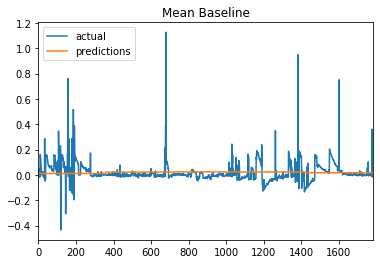


MSE: 2.71579


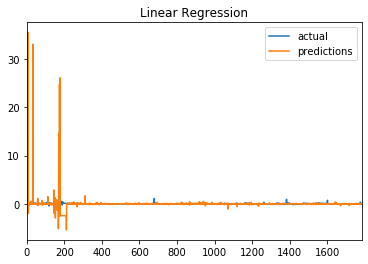


MSE: 0.00757


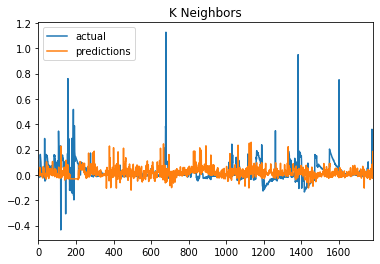


MSE: 0.00687


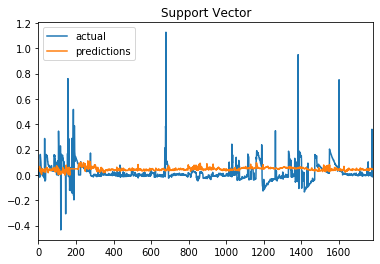


MSE: 0.00661


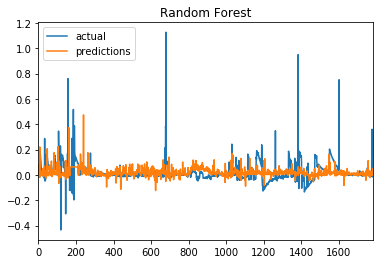


MSE: 0.18853


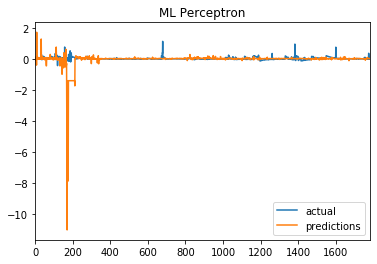

In [244]:
# X, y = get_X_y(delta_12h, delta_12h.columns[:4], delta_12h.columns[5])
# start_h = Data.snow_estimates[Data.snow_estimates.columns[116]][0]
for name, model in models:
    cross_val(model, X, y, name=name, splitf=KFold)
#     if name == 'Random Forest':
#         model.fit(X, y)
        # print(model.feature_importances_)

MSE: 0.00615


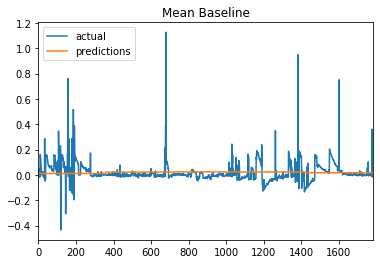


MSE: 2.71579


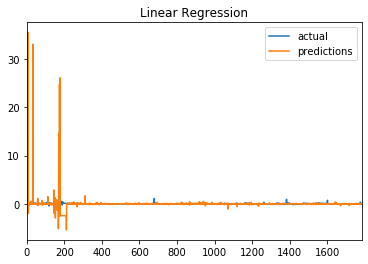


MSE: 0.00713


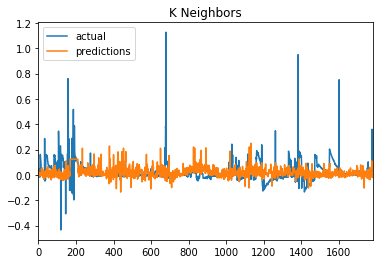


MSE: 0.00806


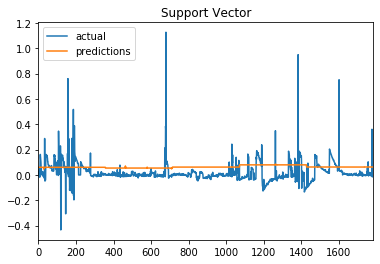


MSE: 0.0066


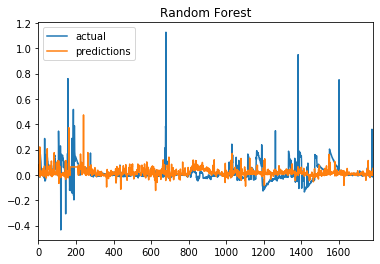


MSE: 1543.01346


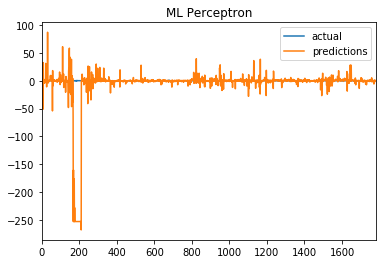

In [224]:
for name, model in Data.models:
    cross_val(model, X, y, name=name, splitf=KFold)

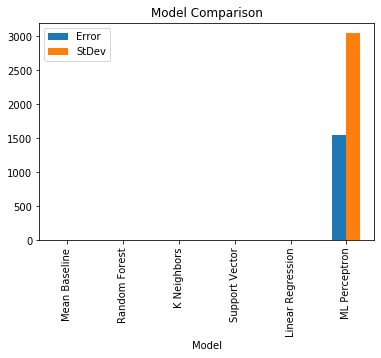

In [228]:
# X, y = get_X_y(delta_12h, delta_12h.columns[:4], delta_12h.columns[5])
compare_models(Data.models, X, y)

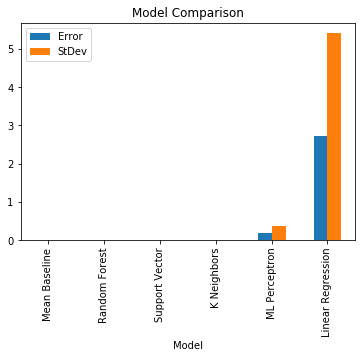

In [229]:
compare_models(models, X, y)

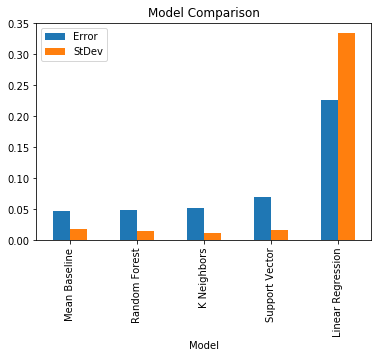

In [238]:
compare_models(Data.models[:-1], X, y, scoring = 'neg_mean_absolute_error')

In [ ]:
# next actually test it (well... check on how to normalize)

In [213]:
X

[[[-31.5, 685.8, 2.1, 103.0, 53.6],
  [-43.0, 685.8, 2.1, 104.0, 54.0],
  [-48.0, 685.7, 2.4, 100.0, 54.0],
  [-54.0, 685.7, 2.4, 98.0, 53.6],
  [-51.7, 685.7, 2.3, 94.0, 54.0],
  [-40.7, 685.6, 2.7, 90.0, 54.0],
  [-57.2, 685.6, 2.6, 92.0, 54.0],
  [-46.6, 685.6, 2.6, 91.0, 54.0],
  [-48.4, 685.6, 2.6, 91.0, 54.0],
  [-51.7, 685.5, 2.8, 92.0, 54.0],
  [-52.2, 685.5, 3.2, 87.0, 54.2],
  [-42.2, 685.6, 2.9, 88.0, 54.0],
  [-45.4, 685.6, 3.0, 89.0, 54.0],
  [-50.5, 685.5, 3.0, 93.0, 54.3],
  [-51.2, 685.5, 2.8, 96.0, 54.0],
  [-48.8, 685.5, 2.8, 96.0, 54.0],
  [-53.4, 685.5, 2.6, 94.0, 54.0],
  [-51.9, 685.5, 2.5, 97.0, 54.0],
  [-53.1, 685.4, 2.6, 96.0, 54.0],
  [-53.6, 685.4, 2.4, 97.0, 54.0],
  [-51.8, 685.4, 2.6, 99.0, 54.0],
  [-55.0, 685.3, 2.2, 104.0, 53.8],
  [-52.2, 685.3, 2.5, 98.0, 54.0],
  [-47.5, 685.3, 2.3, 95.0, 54.0],
  [-55.6, 685.3, 2.0, 97.0, 54.0],
  [-52.1, 685.3, 2.3, 97.0, 54.0],
  [-49.9, 685.3, 2.4, 96.0, 53.0],
  [-51.4, 685.2, 2.4, 97.0, 54.0],
  [-55.2, 685.2,

In [214]:
y

[-0.006225782110007572,
 0.010453287692271829,
 0.019452747694842287,
 -0.002051758445226426,
 0.024956319495650803,
 0.04931587531877568,
 -0.00927796703737016,
 -0.017703166210750965,
 0.0007863997075574503,
 0.13717597466406772,
 0.16196605107023032,
 0.1416381932588351,
 0.12206160897580531,
 0.1024494384388035,
 0.067529123140325,
 0.05374483685558573,
 0.017421638290450403,
 0.01699052730680961,
 0.005694391545603139,
 0.00753084594304454,
 0.02464589978109899,
 -0.0038925289745463942,
 0.001393928421329349,
 0.025579612904955695,
 -0.008911173335441447,
 0.0039130500707429405,
 0.017615699055234302,
 -0.007531723925552569,
 0.017365784390229067,
 -0.01197525438008995,
 -0.019586395711257865,
 -0.0244072998081748,
 -0.025780495256633174,
 0.28791321277743975,
 -0.0376921578997127,
 -0.04837283152143357,
 -0.027411102873351467,
 -0.04254580157974175,
 -0.028399566482413263,
 0.13462145723963914,
 0.14685815749843556,
 0.16174783823571204,
 0.15157353075250768,
 0.15672055211085478

In [211]:
sdate

Timestamp('2017-03-10 12:10:10')

In [198]:
sdate = semi_daily_heights['Date'][1999]

In [199]:
edate = semi_daily_heights['Date'][2000]

In [201]:
edate

Timestamp('2020-02-26 12:10:09')

In [190]:
weather

,Temp,Pres,Ws,Wd,Hum,Date
0,-23.7,700.8,2.5,22.0,72.1,2017-01-01 00:10:00
1,-23.7,700.8,2.5,23.0,72.0,2017-01-01 00:20:00
2,-23.5,700.8,2.4,24.0,72.0,2017-01-01 00:30:00
3,-23.4,700.8,2.1,66.0,71.0,2017-01-01 00:40:00
4,-23.3,700.8,1.8,30.0,71.0,2017-01-01 00:50:00
...,...,...,...,...,...,...
4459,-30.2,686.2,1.8,114.0,65.0,2020-12-31 23:20:00
4460,-30.3,686.2,1.9,114.0,65.0,2020-12-31 23:30:00
4461,-30.2,686.1,2.0,111.0,65.0,2020-12-31 23:40:00
4462,-30.2,686.1,1.9,111.0,65.0,2020-12-31 23:50:00


In [196]:
edate

Timestamp('2020-02-26 12:10:09')

In [195]:
edate in weather['Date']

False

In [204]:
weather[(sdate <= weather.Date) & (weather.Date <= edate)]

,Temp,Pres,Ws,Wd,Hum,Date
3601,-46.7,690.5,3.5,69.0,60.0,2020-02-26 00:20:00
3602,-46.7,690.5,3.4,70.0,60.0,2020-02-26 00:30:00
3603,-46.7,690.5,3.5,65.0,444.0,2020-02-26 00:40:00
3604,-46.8,690.5,3.6,64.0,59.4,2020-02-26 00:50:00
3605,-46.8,690.5,3.6,62.0,59.3,2020-02-26 01:00:00
...,...,...,...,...,...,...
3668,-45.7,690.9,4.2,59.0,59.2,2020-02-26 11:30:00
3669,-45.7,691.0,4.1,57.0,59.0,2020-02-26 11:40:00
3670,-45.6,691.0,4.3,54.0,59.0,2020-02-26 11:50:00
3671,-45.5,691.0,4.5,54.0,59.0,2020-02-26 12:00:00
